# GLTF 格式教學 Mesh 篇

<a href="https://colab.research.google.com/github/CSP-GD/notes/blob/master/practice/file_format/gltf格式解析/mesh/mesh.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[`Open in observablehq`](https://observablehq.com/@toonnyy8/gltf-mesh)

![圖 1. meshes \[1\]](https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf格式解析/mesh/gltfOverview-2.0.0b-mesh.png)

圖 1. meshes \[1\]

此版本暫時不探討 morph 的部分

In [1]:
!wget -q https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf格式解析/gltf-tools.ipynb -O gltf-tools.ipynb
%run ./gltf-tools.ipynb

glTF_tools is loaded


In [2]:
!wget -q https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf格式解析/mesh/cube.glb -O cube.glb
glb_file = open('./cube.glb', 'rb')
glb_bytes = glb_file.read()
model, buffers = glTF_tools.glb_loader(glb_bytes)
model = glTF_tools.model_norm(model)

glTF_tools.render_JSON(model)

# Using OpenGL with Colab Cloud GPUs

This notebook demonstrates obtaining OpenGL context on GPU Colab kernels.

## 建立 OpenGL Context

In [0]:
!wget -q https://raw.githubusercontent.com/tensorflow/lucid/master/lucid/misc/gl/glcontext.py -O glcontext.py
from glcontext import create_opengl_context

In [4]:
# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl

# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 640, 480
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 418.67'
b'NVIDIA Corporation'


## 建立並編譯 shader

In [0]:
vert = """
#version 330

// 物件預設頂點位置
layout (location = 0) in vec3 POSITION;

// 物件預設法向量
layout (location = 1) in vec3 NORMAL;

layout (location = 2) in vec2 TEXCOORD_0;

layout (location = 3) in vec4 JOINTS_0;

layout (location = 4) in vec4 WEIGHTS_0;

uniform mat4 MVP;

void main(){
    gl_Position = MVP * vec4(POSITION, 1.0);
}
"""

In [0]:
frag = """
#version 330

out vec4 color;

void main() {
    color = vec4(1.0, 1.0, 0.0, 0.5);
}
"""

In [0]:
from OpenGL.GL import shaders
main_program = \
shaders.compileProgram(
    shaders.compileShader(
        vert,
        gl.GL_VERTEX_SHADER,
    ),
    shaders.compileShader(
        frag,
        gl.GL_FRAGMENT_SHADER,
    ),
)

gl.glUseProgram(main_program)

## 利用 glTF 中的 bufferView 建立 vertex buffer object

In [0]:
def create_vbo(gl, buffer_view, buffer):
    buffer = buffers[buffer_view.get("buffer")]

    target = buffer_view.get("target")
    byte_offset = buffer_view.get("byteOffset")
    byte_length = buffer_view.get("byteLength")

    vbo = gl.constants.GLuint()
    gl.glCreateBuffers(1, gl.ctypes.pointer(vbo))
    gl.glBindBuffer(
        target,
        vbo,
    )
    
    gl.glBufferData(
        target,
        byte_length,
        buffer[byte_offset:byte_offset+byte_length],
        gl.GL_STATIC_DRAW,
    )

    gl.glBindBuffer(
        target,
        0,
    )
    return vbo


### 將 bufferView 全部都建立成 vertex buffer object

In [0]:
vbos = \
[
    create_vbo(
        gl,
        buffer_view,
        buffers[buffer_view.get("buffer")],
    ) for buffer_view in model["bufferViews"]
]

## glTF 中的 Accessor 是用來設定 vertex attribute pointer

In [0]:
def set_vertex_attribute(gl, program, attrib_name, accessor, buffer_view):
    attribute = gl.glGetAttribLocation(program, attrib_name)

    if attribute != -1:
        type2sizes = {
            "SCALAR": [1],
            "VEC2": [2],
            "VEC3": [3],
            "VEC4": [4],
            "MAT2": [2, 2],
            "MAT3": [3, 3, 3],
            "MAT4": [4, 4, 4, 4],
        }

        stride = buffer_view.get("byteStride")

        componentType = accessor.get("componentType")
        # glTF 的標準中並未提及 normalized 屬性，因此預設成 False
        normalize = False
        byte_offset = accessor.get("byteOffset")

        sizes = type2sizes[accessor["type"]]

        for idx,size in enumerate(sizes):
            gl.glEnableVertexAttribArray(attribute + idx)
            gl.glVertexAttribPointer(
                attribute + idx,
                size,
                componentType,
                normalize,
                stride,
                byte_offset,
            )


## 有了 set_vertex_attribute 這個函數與 vbos，就可以建立出 primitive (vao) 了

In [0]:
def create_primitive(gl, program, model, primitive, vbos):
    vao = gl.constants.GLuint()
    gl.glCreateVertexArrays(1, gl.ctypes.pointer(vao))
    gl.glBindVertexArray(vao)
    for attrib_name in primitive["attributes"].keys():
        accessor = model.get("accessors")[primitive.get("attributes")[attrib_name]]
        buffer_view = model.get("bufferViews")[accessor.get("bufferView")]
        gl.glBindBuffer(
            gl.GL_ARRAY_BUFFER,
            vbos[accessor.get("bufferView")],
        )
        set_vertex_attribute(gl, program, attrib_name, accessor, buffer_view)

    gl.glBindBuffer(
        gl.GL_ELEMENT_ARRAY_BUFFER,
        vbos[primitive.get("indices")],
    )
    gl.glBindVertexArray(gl.constants.GLuint(0))

    return vao

## 而每個 mesh 又是由多個 primitive 組成

In [0]:
def create_mesh(gl, program, mesh, model, vbos):
    primitives = model["meshes"][mesh]["primitives"]
    return \
    [
        {
            "primitive":create_primitive(gl, program, model, primitive, vbos),
            "componentType":model.get("accessors")[primitive.get("indices")].get("componentType"),
            "count":model.get("accessors")[primitive.get("indices")].get("count"),
        } for primitive in primitives
    ]

In [13]:
mesh_elements = create_mesh(gl, main_program, 0, model, vbos)
mesh_elements

[{'componentType': 5123, 'count': 36, 'primitive': c_uint(1)}]

In [0]:
import numpy as np
import PIL

def render_mesh(gl, program, mvp, mesh_elements):
    for mesh_element in mesh_elements:
        gl.glBindVertexArray(mesh_element["primitive"])

        gl.glUniformMatrix4fv(
            gl.glGetUniformLocation(
                program,
                "MVP"
            ),
            1,
            False,
            mvp.to_list(),
        )

        gl.glDrawElements(
            gl.GL_TRIANGLES, 
            mesh_element["count"],
            mesh_element["componentType"],
            gl.constants.GLvoidp(0),
        )

        
    img_buf = gl.glReadPixels(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
    img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]

    return PIL.Image.fromarray(img)

In [0]:
!pip install -q PyGLM

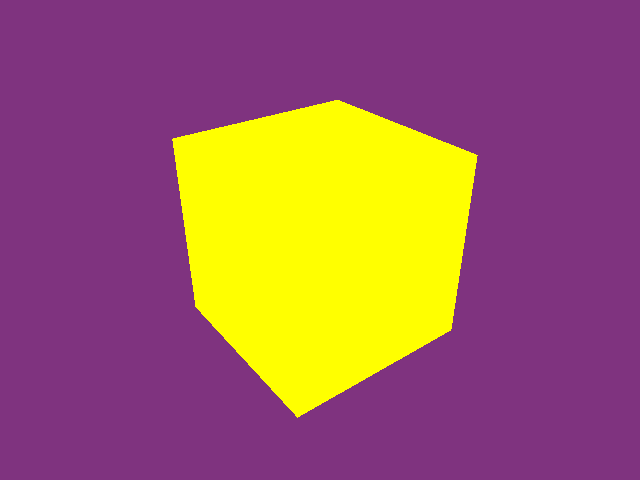

In [16]:
import glm
import math

# Clear to black, fully opaque
gl.glClearColor(0.5, 0.2, 0.5, 1.0)
# Clear everything
gl.glClearDepth(1.0) 
# Enable depth testing
gl.glEnable(gl.GL_DEPTH_TEST)
# Near things obscure far things
gl.glDepthFunc(gl.GL_LEQUAL)

gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)

fieldOfView = 45 * math.pi / 180 # in radians
aspect = WIDTH / HEIGHT
zNear = 0.1
zFar = 1000.0

projectionMatrix = \
glm.perspective(
    fieldOfView,
    aspect,
    zNear,
    zFar,
)

cameraMatrix = \
glm.lookAt(
    glm.vec3(4, 3, 3),
    glm.vec3(0, 0, 0),
    glm.vec3(0, 1, 0),
)

postureMatrix = \
glm.scale(
    glm.mat4(),
    glm.vec3(1.0, 1.0, 1.0),
)

mvp = projectionMatrix * cameraMatrix * postureMatrix

render_mesh(gl, main_program, mvp, mesh_elements)